# Create Field Management Zones using Soil Moisture Data

This notebook is a follow up example to the NDVI exercise covered during the workshop. The dataset in this notebook consists of in situ soil moisture surveys conducted in the same Mortimers field using a hand-held soil moisture sensor (Hydrosense 2, Campbell Scientific).

The challenge in this exercise is that the point measurements need to first be converted into a raster (euqual-spasing grid) before they can be combined. The goal is to do the same: normalize soil moisture surveys using the relative difference, stack all the surveys, then compute the mean relative difference, and then use this layer to do the clustering.

Notebook created by Andres Patrignani - November 2024

Dataset collected by Pedro Rossini in 2017


In [1]:
# Import modules
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata, RBFInterpolator

from sklearn.cluster import BisectingKMeans
from sklearn.impute import SimpleImputer

In [3]:
# Set format of axes without offset in the form of scientific notation
plt.rcParams['axes.formatter.useoffset'] = False


## Inspect soil moisture surveys

In [6]:
df_sm = pd.read_csv('sm_data/soil_moisture_surveys.csv', parse_dates=['TimeStamp'])
df_sm.head(3)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor,Probe_Model,Period ( us ),Period
0,2017-05-09 07:08:00,56,ZONE 00006,38.71096,-97.43689,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN
1,2017-05-09 07:08:00,57,ZONE 00006,38.71095,-97.43687,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN
2,2017-05-09 07:08:00,58,"ZONE 00006, ZONE 00007",38.71094,-97.43653,24.31,1.4886,1.2611,13.0000,NaN,NaN,CD659 12cm rods,NaN,NaN


In [8]:
# Define correction function based on Patrignani et al. (2022) for Hydrosense II hand-held sensor
correction_fn = lambda x: -0.0974 + (0.0735 * np.sqrt(x))**0.78


In [10]:
# Apply correction function
df_sm['Moisture_corrected'] = correction_fn(df_sm['Permittivity'])


### Create GeoDataframe
We will now convert the Pandas Dataframe into a GeoPandas GeoDataframe.

In [13]:
points = gpd.points_from_xy(df_sm['Longitude'], df_sm['Latitude'], crs="EPSG:4326")
field_points = gpd.GeoDataFrame(df_sm, geometry=points)
print(field_points.shape)
field_points.head(5)

(2687, 16)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor,Probe_Model,Period ( us ),Period,Moisture_corrected,geometry
0,2017-05-09 07:08:00,56,ZONE 00006,38.71096,-97.43689,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284648,POINT (-97.43689 38.71096)
1,2017-05-09 07:08:00,57,ZONE 00006,38.71095,-97.43687,28.65,1.5541,1.3962,15.7012,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284648,POINT (-97.43687 38.71095)
2,2017-05-09 07:08:00,58,"ZONE 00006, ZONE 00007",38.71094,-97.43653,24.31,1.4886,1.2611,13.0000,NaN,NaN,CD659 12cm rods,NaN,NaN,0.257529,POINT (-97.43653 38.71094)
3,2017-05-09 07:09:00,59,"ZONE 00006, ZONE 00007",38.71094,-97.43625,25.70,1.5078,1.2071,13.8298,NaN,NaN,CD659 12cm rods,NaN,NaN,0.266199,POINT (-97.43625 38.71094)
4,2017-05-09 07:09:00,60,ZONE 00007,38.71094,-97.43597,28.63,1.5519,1.2712,15.6838,NaN,NaN,CD659 12cm rods,NaN,NaN,0.284483,POINT (-97.43597 38.71094)


In [15]:
# Convert geographic coordinates to projected coordinates 
# We will use UTM-14 for Kansas (https://epsg.io/32614)
field_points = field_points.to_crs(crs=32614)


In [21]:
# Approximate field boundary using the convex hull
field_bnd = gpd.GeoDataFrame(geometry=[field_points.union_all().convex_hull])

# Alternatively you can read your field boundary in geojson, KML, or shapefile format
# field_bnd = gpd.read_file('sm_data/neon_kona_bnd.geojson').to_crs(crs=32614)


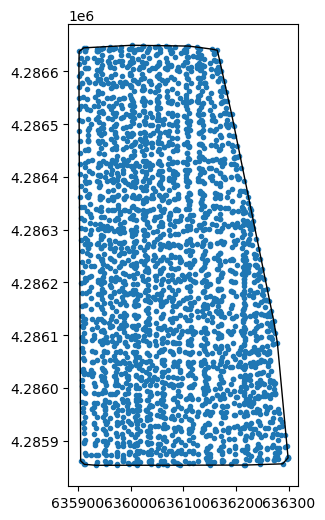

In [23]:
# Display all field points and the field boundary
fig, ax = plt.subplots(figsize=(6,6))
field_points.plot(ax=ax, marker='.')
field_bnd.plot(ax=ax, facecolor='None')
plt.show()


### Create field grid
Now need to generate a raster layer that spans the entire field, with each grid cell containing a value estimated from nearby point observations.

In [33]:
# Get bounds considering all points (note that bounds is for each geometry, while total bounds is for the entire GeoDataFrame)
xmin, ymin, xmax, ymax = field_points.total_bounds # .bounds gives the boundaries for each geoemtry in the gdf


In [35]:
# Create grid
xdelta = 5 # meters
ydelta = 5 # meters

xspacing = round((xmax-xmin)/xdelta)
yspacing = round((ymax-ymin)/ydelta)

xvec = np.linspace(xmin,xmax,xspacing)
yvec = np.linspace(ymin,ymax,yspacing)

X_grid,Y_grid = np.meshgrid(xvec,yvec)
Z_grid = np.full_like(X_grid, np.nan)


In [37]:
# Create raster using xarray
field_grid = xr.DataArray(Z_grid, coords=[yvec, xvec], dims=["y", "x"])
field_grid


<xarray.DataArray (y: 159, x: 79)> Size: 100kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 1kB 4.286e+06 4.286e+06 ... 4.287e+06 4.287e+06
  * x        (x) float64 632B 6.359e+05 6.359e+05 ... 6.363e+05 6.363e+05

In [39]:
# Create a GeoDataframe with the centroids, so that we can use them to find cells inside and outside of the field boundary
xy_points = gpd.points_from_xy(X_grid.flatten(), Y_grid.flatten(), crs=32614)
field_grid_centroids = gpd.GeoDataFrame(geometry=xy_points)


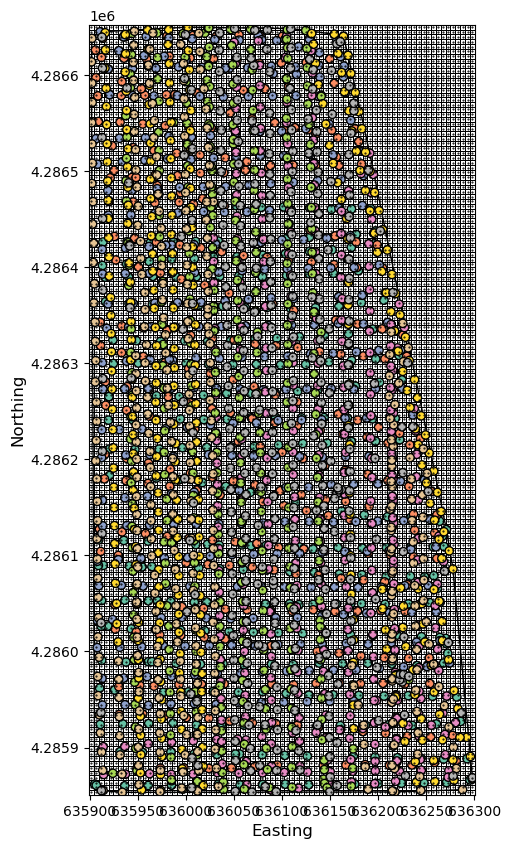

In [62]:
# Overlay all vector (sampling points ) and raster data
fig, ax = plt.subplots(figsize=(10,10))
field_grid.plot(ax=ax, edgecolor='k', linewidth=0.5, add_colorbar=False)
field_bnd.plot(ax=ax, color='None')
field_points.plot(ax=ax, edgecolor='k', marker='o', c=field_points['TimeStamp'].dt.dayofyear, cmap='Set2')
field_grid_centroids.plot(ax=ax, marker='.', markersize=1, color='k')
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)
plt.show()


### Create mask
The mask represents the grid cells that are outside of the field boundary and that therefore we want to ignore during interpolation and the overall data analysis.

In [65]:
# Find grid points inside of field boundary
field_mask = ~field_grid_centroids.within(field_bnd['geometry'].iloc[0]) # For a one-to-many we need to pass the Shapely polygon
#field_mask = gdf_grid.geometry.apply(field_bnd['geometry'].iloc[0].contains) # Alternative using the contains method

# Convert the GeoSeries (1D column) to matrix form (2d array)
field_mask = np.reshape(field_mask.values, X_grid.shape)

# Convert array into Xarray
field_mask = xr.DataArray(field_mask, coords=[yvec, xvec], dims=["y", "x"])


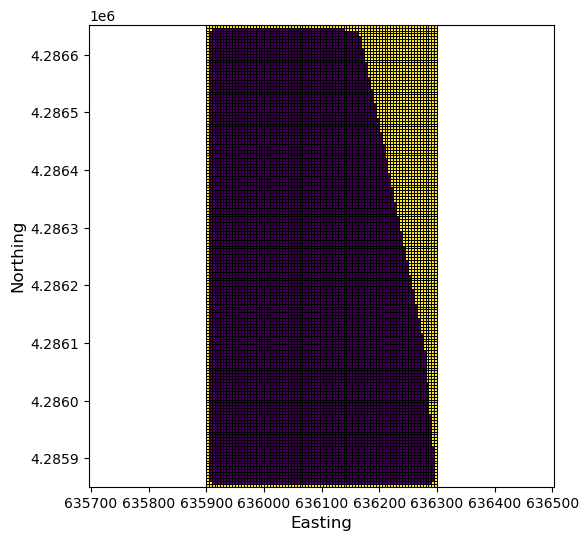

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
field_mask.plot(ax=ax, edgecolor='k', linewidth=0.5, add_colorbar=False)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)
ax.axis('equal')
plt.show()


### Interpolate soil moisture for each survey
Here we will interpolate point values collected during each survey to the regular grid. There will be one grid per survey.


In [70]:
unique_survey_dates = field_points['TimeStamp'].dt.date.unique()
all_grids = np.empty((X_grid.shape[0], X_grid.shape[1], len(unique_survey_dates)))

for k,survey_date in enumerate(unique_survey_dates):
    idx_survey = field_points['TimeStamp'].dt.date == survey_date

    xp = field_points.get_coordinates().loc[idx_survey,'x'].values
    yp = field_points.get_coordinates().loc[idx_survey,'y'].values
    zp = field_points.loc[idx_survey,'Moisture_corrected'].values

    # Use a radial basis function interpolator
    xp += np.random.normal(0, 1e-6, size=xp.shape) # Need to add noise to avoid singularity due to points with same coordinates (sensor had 3 m GPS receiver)
    yp += np.random.normal(0, 1e-6, size=yp.shape)
    rbf = RBFInterpolator(np.column_stack((xp,yp)), zp, kernel='linear', neighbors=20) # cubic and think_place_spline give some badly interpolated maps
    interp_survey = rbf(np.column_stack((X_grid.flatten(), Y_grid.flatten())))
    interp_survey = interp_survey.reshape(X_grid.shape)
    
    # Use griddata
    #interp_survey = griddata((xp, yp), zp, (X_grid, Y_grid), method='linear')

    # Replace values outside field boundary with NaN
    interp_survey[field_mask] = np.nan

    # Compute the relative difference
    interp_survey_norm =  (interp_survey - np.nanmean(interp_survey))/np.nanmean(interp_survey)
    
    # Append interpolated grid
    all_grids[:,:,k] = interp_survey_norm

In [71]:
# Create a space-time DataArray with all the interpolated surveys
field_interp_grids = xr.DataArray(all_grids, coords=[yvec, xvec, unique_survey_dates], dims=["y", "x", "date"])


In [72]:
# Plot particular survey
#field_interp_grids.sel(date=unique_survey_dates[1]).plot()


In [73]:
# Find the number of surveys to inform the number of subplots
print(len(unique_survey_dates))

7


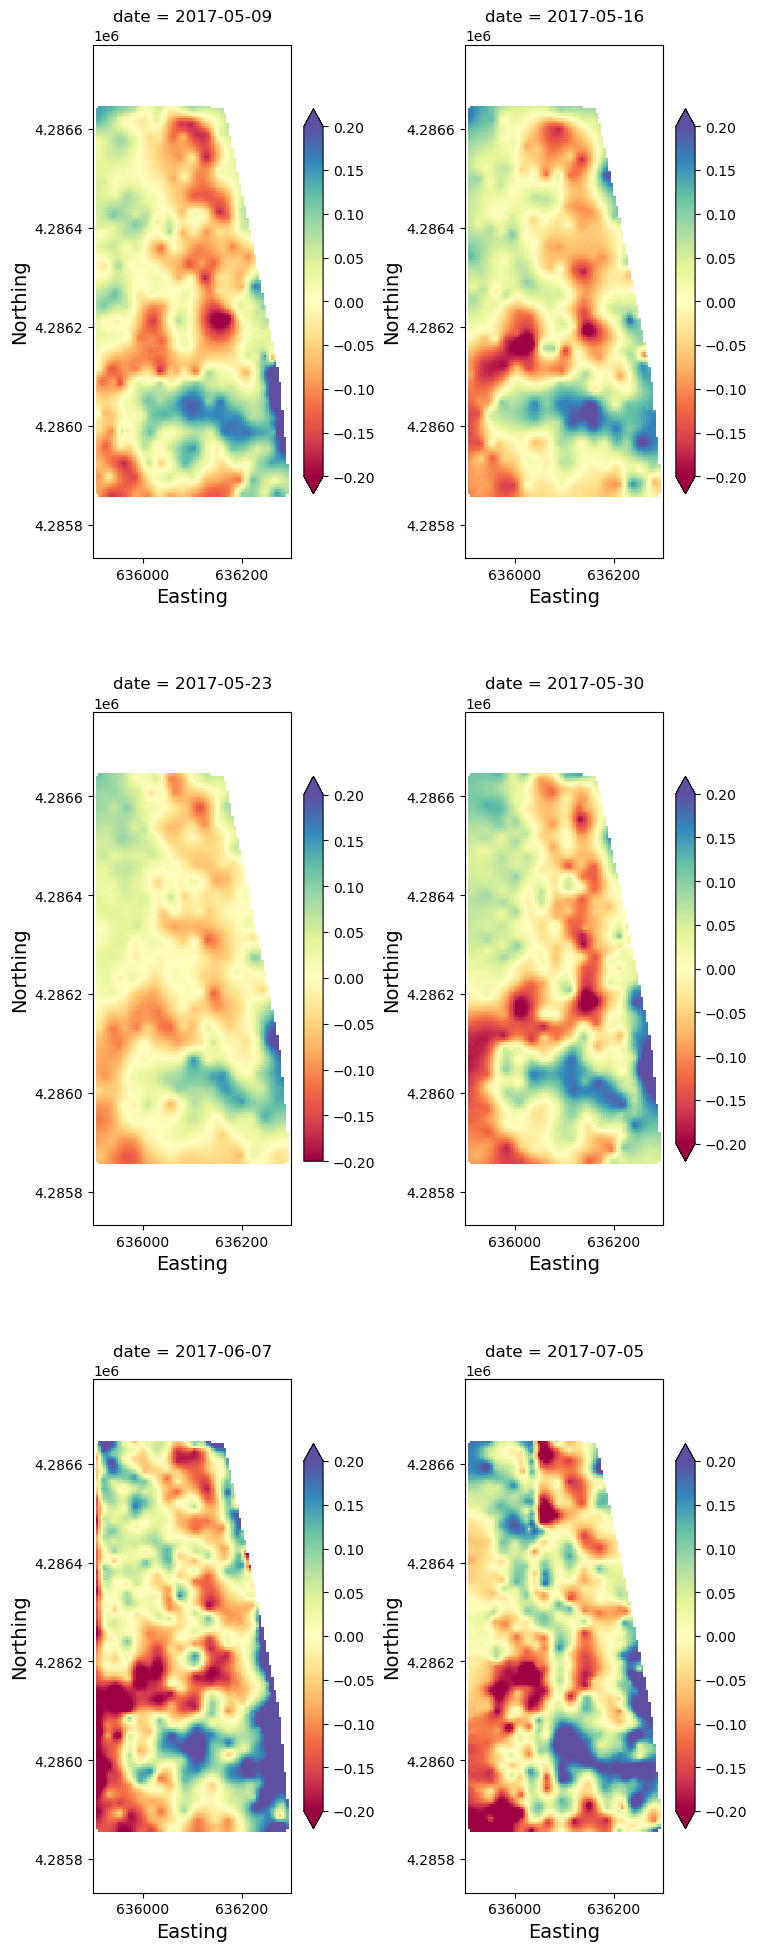

In [78]:
# Plot all of them
fig, axs = plt.subplots(figsize=(8, 24), nrows=3, ncols=2)
for n,ax in enumerate(axs.flat):
    field_interp_grids.sel(date=unique_survey_dates[n]).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='Spectral', cbar_kwargs={"shrink":0.75})
    ax.set_xlabel('Easting', fontsize=14)
    ax.set_ylabel('Northing', fontsize=14)
    ax.axis('equal')
    
fig.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

In [80]:
# Compute mean relative diffences
field_mrd = field_interp_grids.mean(axis=2)
field_sd = field_interp_grids.std(axis=2)


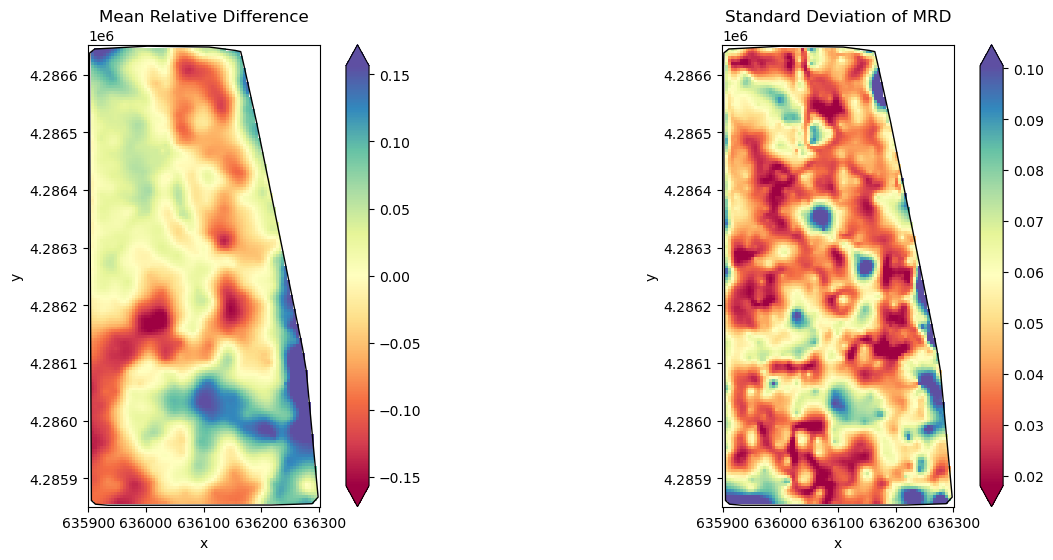

In [82]:
fig, ax = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
field_mrd.plot(ax=ax[0], cmap='Spectral', robust=True)
field_bnd.plot(ax=ax[0], facecolor='None', edgecolor='k', linewidth=1)
ax[0].set_title('Mean Relative Difference')

field_sd.plot(ax=ax[1], cmap='Spectral', robust=True)
field_bnd.plot(ax=ax[1], facecolor='None', edgecolor='k', linewidth=1)
ax[1].set_title('Standard Deviation of MRD')

plt.show()


### Determine management zones based on soil moisture

In [ ]:
# To do by students following NDVI example